In [1]:
import os
import pandas as pd
import janitor
import numpy as np
pd.set_option('display.max_columns', 100)

import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid', palette='dark') #  Darkgrid Whitegrid Dark White Ticksimport matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats

def change_width(ax, new_value) :
    # https://stackoverflow.com/a/44542112
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

def fit_exp(x , y, w=None):
    # https://rowannicholls.github.io/python/curve_fitting/exponential.html
#     p = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))    
    p = np.polyfit(x, np.log(y), 1)    
    a = np.exp(p[1])
    b = p[0]
    x_fitted = np.linspace(np.min(x), np.max(x), 100)
    y_fitted = a * np.exp(b * x_fitted)
    return x_fitted, y_fitted

def save_mpl_fig(savepath):
    plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)
    plt.savefig(f"{savepath}.png", dpi=120, bbox_inches="tight", pad_inches=0)

def pandas_to_tex(df, texfile):
    if texfile.split(".")[-1] != ".tex":
        texfile += ".tex"
        
    tex_table = df.to_latex(index=False, header=False)
    tex_table_fragment = "\n".join(tex_table.split("\n")[2:-3])
    
    with open(texfile, "w") as tf:
        tf.write(tex_table_fragment)
    return None

DATAPATH = "../adult-data"        
FIGSAVEDIR = "../figs"

In [2]:
# (fold cell) Load and prep web browsing data
# output = df with visits to adult sites
usecols_web_desktop = ["caseid", "category", "private_domain", "visit_duration", "visit_time_local"]
usecols = ["caseid", "category", "private_domain", "page_duration", "session_start_time"]

df = (pd.concat([
        # Get web_mobile
        pd.read_csv(
            os.path.join(DATAPATH, "output/realityMine_web_mobile_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ), 
        # Get web_desktop
        pd.read_csv(
            os.path.join(DATAPATH, "output/realityMine_web_desktop_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ),
        # Get web
        (pd.read_csv(
            os.path.join(DATAPATH, "output/realityMine_web_2022-06-01_2022-06-30.csv"),
            usecols=usecols,
            low_memory=False,
        )
         # Renaming columns to be consistent w/ web_mobile & web_desktop
         .rename_column("session_start_time", "visit_time_local")
         .rename_column("page_duration", "visit_duration")
        )
    ])
     )
print("output = df with web browses")
print(f"{len(df)=:,}")
df.head()

output = df with web browses
len(df)=5,090,441


,caseid,private_domain,category,visit_time_local,visit_duration
0,210362181,liveineverett.com,NaN,2022-05-31 17:19:01,50
1,210362181,wa.gov,"Education, Government",2022-05-31 19:28:41,48
2,210362181,yahoo.com,Economy and Finance,2022-06-01 03:16:33,1
3,210362181,collider.com,Entertainment,2022-06-01 03:29:15,60
4,210362181,yahoo.com,"Education, News and Media",2022-06-01 03:42:43,83


In [3]:
# (fold cell) Load the 1200 individual metadata
df_ind_metadata = (
    pd.read_csv(os.path.join(DATAPATH, "SOOD0001_OUTPUT.csv"))
    .case_when(
        lambda df: df.pid7==1, "D", 
        lambda df: df.pid7==2, "D", 
        lambda df: df.pid7==3, "D", 
        lambda df: df.pid7==4, "I", 
        lambda df: df.pid7==5, "R", 
        lambda df: df.pid7==6, "R",  
        lambda df: df.pid7==7, "R", 
        np.nan, 
        column_name="party"
    )
    .assign(
        caseid=lambda df: df.caseid.apply(int),
        birthyr=lambda df: df.birthyr.apply(int),
    )
)
print(f"{len(df_ind_metadata)=}")
df_ind_metadata.head(3)

len(df_ind_metadata)=1200


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party
0,200661421,1963,2,1,4,3,3,1,39,2,D
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN
2,200953869,1959,2,1,5,2,7,2,42,1,R


In [4]:
# (fold cell) Get individual level total visit durations to adult and non-adult sites
df_ind = (df_ind_metadata
          # Get total adult site visit duration
          .merge((df
                  .query("category.str.contains('adult', case=False, na=False)")
                  .groupby("caseid").size().reset_index()
                  .rename_column(0, "visits_adult")
                 ), how="left", on="caseid", validate="1:1"
                )
          # Get total adult site visit duration
          .merge((df
                  .query("~category.str.contains('adult', case=False, na=False)")
                  .groupby("caseid").size().reset_index()
                  .rename_column(0, "visits_nonadult")
                 ), how="left", on="caseid", validate="1:1"
                )          
          # If adult or non-adult (exclusive) is nan, impute as zero
          .assign(
              visits_adult=lambda df: np.where(
                  pd.isna(df.visits_adult) & ~pd.isna(df.visits_nonadult), 0, df.visits_adult
              )
          )
          .assign(
              visits_nonadult=lambda df: np.where(
                  ~pd.isna(df.visits_adult) & pd.isna(df.visits_nonadult), 0, df.visits_nonadult
              )          
          )
          # Get total visits
          .assign(
              visits=lambda df: df.visits_adult + df.visits_nonadult,
              prop_adult_visits=lambda df: 100 * (df.visits_adult / df.visits),
          )
#           .dropna(subset="prop_adult_visits")
#           .query("prop_adult_visits>0")
#           # Make decile bins
          .assign(             
#               decile_visits_adult=lambda df: pd.qcut(df.visits_adult, **qcut_opts),
#               decile_party=lambda df: (df.groupby("party")["prop_adult_duration"]
#                                            .transform(lambda x: pd.qcut(x, **qcut_opts))
#                                           ),
#               quantiles_party_visits_adult=lambda df: (df.groupby("party")["visits_adult"]
#                                        .transform(lambda x: pd.qcut(x, **quantiles_cut_opts))
#                                       ),                           
                 )
# # #           .assign(decile_party=lambda df: df.decile_party.apply(int))
         )
assert df_ind.prop_adult_visits.min()>=0
assert df_ind.prop_adult_visits.max()<=100
df_ind

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.000000
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.000000
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1802885,1935,1,1,6,4,5,2,12,3,R,NaN,NaN,NaN,NaN
1196,1809723,1943,1,1,2,1,1,1,51,3,D,NaN,NaN,NaN,NaN
1197,1827351,1947,1,1,5,3,4,1,31,2,I,NaN,NaN,NaN,NaN
1198,1924249,1980,1,7,4,2,7,2,6,4,R,NaN,NaN,NaN,NaN


### Distribution of visits to adult sites

In [5]:
# (fold cell) Prep data
qcut_opts = {"q":10, "precision":1, "labels": range(10,101,10), "duplicates": "drop"}

_df = (df_ind
       .query("visits_adult>0")
       .assign(decile_visits_adult=lambda df: pd.qcut(df.visits_adult, **qcut_opts))
      )
_df.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,decile_visits_adult
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,90
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,40
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,30


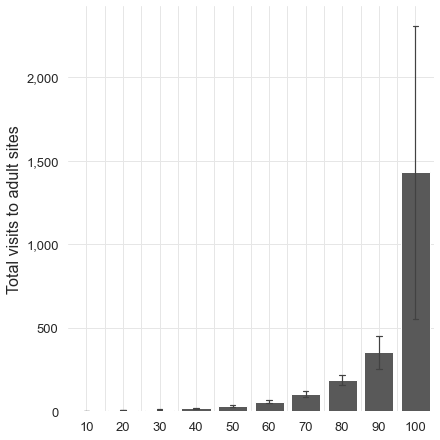

In [6]:
# (fold cell) Plot deciles
scale = .7
fig, ax = plt.subplots(figsize=(9*scale, 9*scale))

sns.barplot(
    x="decile_visits_adult", y="visits_adult", data=_df, 
    color=".35",
    ci="sd",
    errwidth=1.2,
    capsize=.15,
)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("")
ax.set_ylabel("Total visits to adult sites", size=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_visits_to_adultsites"))

In [7]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_deciles = (_df
               .visits.quantile(ntiles)
               .reset_index()
               .rename_column('index', 'Percentile')
               .assign(visits=lambda df: df.visits.apply(int))
              )
pandas_to_tex(tab_deciles, "../tabs/percentiles_visits_adultsites_by_individuals")
tab_deciles

C:\Users\Admin\AppData\Local\Temp\ipykernel_25544\1547161620.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=False, header=False)


,Percentile,visits
0,0.00,65
1,0.10,522
2,0.20,846
3,0.30,1365
4,0.40,2343
5,0.50,3685
6,0.60,4518
7,0.70,7529
8,0.80,10658
9,0.90,19138


### Distribution of visits to adult sites, by partisanship

In [8]:
# (fold cell) Get deciles mean and std
df_decile_agg = (df_ind
                 # Make deciles by parquantiles_adult_visitsty
                 .query("visits_adult>0")
                 .assign(
                     decile_visits_adult=lambda df: (df.groupby("party")["visits_adult"]
                                                     .transform(lambda x: pd.qcut(x, **qcut_opts))
                                                    ),
                 )
                 .groupby(["party", "decile_visits_adult"])["visits_adult"]
                 .agg(["mean", "std"])
                 .reset_index()
                 .assign(std=lambda df: df["std"]/2)
                 .assign(decile_visits_adult=lambda df: df.decile_visits_adult.astype(int))
                 .assign(decile_visits_adult=lambda df: np.where(df.party=="D", df.decile_visits_adult-4, df.decile_visits_adult)                 )
                 .assign(decile_visits_adult=lambda df: np.where(df.party=="R", df.decile_visits_adult-6, df.decile_visits_adult)                 )
                )
df_decile_agg.head(4)

,party,decile_visits_adult,mean,std
0,D,6,2.000000,0.235702
1,D,16,5.142857,0.432219
2,D,26,9.000000,0.707107
3,D,36,12.333333,0.516398


In [9]:
# Prep data for scatter
df_visits = (df_ind
             .dropna(subset="party")
             .query("visits_adult>0")
  
             # Retrieve quantiles of visits to adult sites
             .case_when(
                 # when R, D, or I
                 lambda df: df.party=="R", lambda df: df.visits_adult.apply(lambda x: stats.percentileofscore(df.query("party=='R'").visits_adult.sort_values(), x)),
                 lambda df: df.party=="D", lambda df: df.visits_adult.apply(lambda x: stats.percentileofscore(df.query("party=='D'").visits_adult.sort_values(), x)),
                 lambda df: df.party=="I", lambda df: df.visits_adult.apply(lambda x: stats.percentileofscore(df.query("party=='I'").visits_adult.sort_values(), x)),
                 # else nan
                 np.nan,
                 column_name="quantiles_adult_visits"
             )             
            )
df_visits.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,quantiles_adult_visits
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,34.408602
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,94.444444
20,204288513,1991,1,1,2,3,4,2,54,3,I,38.0,79884.0,79922.0,0.047546,41.666667


In [10]:
# (fold cell) Standard Options
palette = {"R": "Maroon", "D": "Navy"}
errorlinestyle = {"R": "-.", "D": "-"}
scatter_opts = {
    "x":"quantiles_adult_visits", 
    "y":"visits_adult",
    "marker":"x",
    "s":30,
    "linewidths":.8,
    "alpha":.4,
}

errorbar_opts = {
    "x":"decile_visits_adult",
    "y":"mean",
    "yerr":"std",
    "elinewidth":2.5,
    "ls":"none",
    "alpha":.6,
    "zorder":1,    
}
scatter_decile_opts = {
    "x":"decile_visits_adult", 
    "y":"mean",
    "marker":"o",
    "s":60,
    "alpha":.85,
}
line_opts = {
    "lw":1.5,
    "alpha":0.5,
}

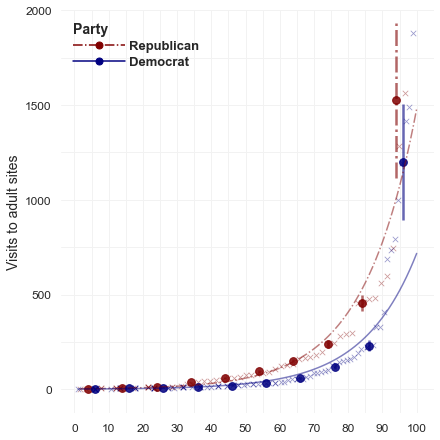

In [11]:
# (fold cell) Plot splits by party
scale = .7
fig, ax = plt.subplots(figsize=(9*scale, 9*scale))

# Scatterpoints for individuals
for party in ["R", "D"]:
    plt.scatter(
        data=df_visits.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_opts
    )
# Error bars
for party in ["R", "D"]:
    eb = plt.errorbar(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **errorbar_opts,
    )
    if party == "R":
        eb[-1][0].set_linestyle(errorlinestyle["R"])

# Scatter for the 2 parties x 10 deciles
for party in ["R", "D"]:
    plt.scatter(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_decile_opts
    )

# Connect deciles
outcome_var = "visits_adult"
running_var = "quantiles_adult_visits"
for party in ["R", "D"]:
    y = df_visits.query(f"party=='{party}'")[outcome_var]
    x = df_visits.query(f"party=='{party}'")[running_var]
    x_fitted, y_fitted = fit_exp(x,y)
    plt.plot(x_fitted, y_fitted, color=palette[party], linestyle=errorlinestyle[party], **line_opts)

# Figure settings
ax.set_xticks(range(0,110,10))
ax.set_xlabel("")
ax.set_ylabel("Visits to adult sites", size=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks(range(0,2500,500))
ax.set_ylim(ax.get_ylim()[0], 2000)

# Grids
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".95")
ax.yaxis.grid(True, which="both", color=".95")

# Custom Legend
rep_hand = mlines.Line2D([], [], 
                         color='maroon', marker='o', ls="-.",
                         markersize=7, label='Republican'
                        )
dem_hand = mlines.Line2D([], [], 
                         color='navy', marker='o', ls="-",
                         markersize=7, label='Democrat',
                        )
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
#     size=20,
    title="Party", 
    frameon=False,
    prop={'weight':'bold', "size":13},
    title_fontproperties={'weight':'bold', 'size':14},
)
custom_legend._legend_box.align = "left"

sns.despine(left=True,bottom=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_visits_to_adultsites_by_party"))

### Distribution of proportion of visits to adult sites

In [12]:
# (fold cell) Prep data
qcut_opts = {"q":10, "precision":1, "labels": range(10,101,10), "duplicates": "drop"}

_df = (df_ind
       .query("prop_adult_visits>0")
       .assign(decile_prop_adult=lambda df: pd.qcut(df.prop_adult_visits, **qcut_opts))
      )
_df.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,decile_prop_adult
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,70
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,60
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,20


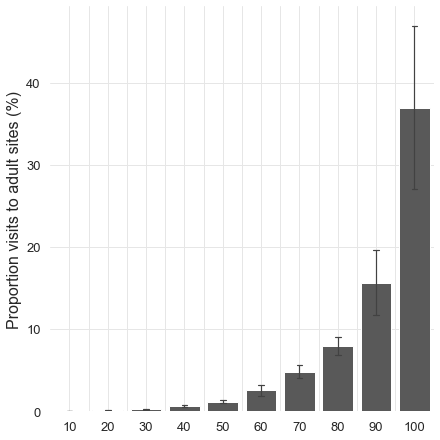

In [13]:
# (fold cell) Plot deciles
scale = .7
fig, ax = plt.subplots(figsize=(9*scale, 9*scale))

sns.barplot(
    x="decile_prop_adult", y="prop_adult_visits", data=_df, 
    color=".35",
    ci="sd",
    errwidth=1.2,
    capsize=.15,
)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("")
ax.set_ylabel("Proportion visits to adult sites (%)", size=16)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_proportion_adultsites_visits"))

In [14]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_deciles = (_df
               .prop_adult_visits.quantile(ntiles)
               .reset_index()
               .rename_column('index', 'Percentile')
               .round(decimals=1)
              )
pandas_to_tex(tab_deciles, "../tabs/percentiles_proportion_adultsites_visits_by_individuals")
tab_deciles

C:\Users\Admin\AppData\Local\Temp\ipykernel_25544\1547161620.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=False, header=False)


,Percentile,prop_adult_visits
0,0.0,0.0
1,0.1,0.1
2,0.2,0.1
3,0.3,0.4
4,0.4,0.9
5,0.5,1.5
6,0.6,3.7
7,0.7,6.3
8,0.8,10.0
9,0.9,23.8


### Distribution of proportion of visits to adult sites, by partisanship

In [15]:
outcome_var = "prop_adult_visits"

In [16]:
# (fold cell) Get deciles mean and std
df_decile_agg = (df_ind
                 # Make deciles by parquantiles_adult_visitsty
                 .query(f"{outcome_var}>0")
                 .assign(
                     decile_prop_adult=lambda df: (df.groupby("party")[outcome_var]
                                                     .transform(lambda x: pd.qcut(x, **qcut_opts))
                                                    ),
                 )
                 .groupby(["party", "decile_prop_adult"])[outcome_var]
                 .agg(["mean", "std"])
                 .reset_index()
                 .assign(std=lambda df: df["std"]/2)
                 .assign(decile_prop_adult=lambda df: df.decile_prop_adult.astype(int))
                 .assign(decile_prop_adult=lambda df: np.where(df.party=="D", df.decile_prop_adult-4, df.decile_prop_adult)                 )
                 .assign(decile_prop_adult=lambda df: np.where(df.party=="R", df.decile_prop_adult-6, df.decile_prop_adult)                 )
                )
df_decile_agg.head(4)

,party,decile_prop_adult,mean,std
0,D,6,0.034682,0.010060
1,D,16,0.095043,0.008524
2,D,26,0.212646,0.029667
3,D,36,0.433074,0.042815


In [17]:
# Prep data for scatter
df_visits = (df_ind
             .dropna(subset="party")
             .query(f"{outcome_var}>0")
             # Retrieve quantiles of visits to adult sites
             .case_when(
                 # when R, D, or I
                 lambda df: df.party=="R", lambda df: df[outcome_var].apply(lambda x: stats.percentileofscore(df.query("party=='R'")[outcome_var].sort_values(), x)),
                 lambda df: df.party=="D", lambda df: df[outcome_var].apply(lambda x: stats.percentileofscore(df.query("party=='D'")[outcome_var].sort_values(), x)),
                 lambda df: df.party=="I", lambda df: df[outcome_var].apply(lambda x: stats.percentileofscore(df.query("party=='I'")[outcome_var].sort_values(), x)),
                 # else nan
                 np.nan,
                 column_name="quantiles_adult_visits_prop"
             )             
            )
df_visits.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,quantiles_adult_visits_prop
4,201590505,1977,1,4,5,3,3,1,6,4,D,11.0,11075.0,11086.0,0.099224,17.204301
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,63.888889
20,204288513,1991,1,1,2,3,4,2,54,3,I,38.0,79884.0,79922.0,0.047546,2.777778


In [18]:
# (fold cell) Standard Options
palette = {"R": "Maroon", "D": "Navy"}
errorlinestyle = {"R": "-.", "D": "-"}
scatter_opts = {
    "x":"quantiles_adult_visits_prop", 
    "y":outcome_var,
    "marker":"x",
    "s":30,
    "linewidths":.8,
    "alpha":.4,
}

errorbar_opts = {
    "x":"decile_prop_adult",
    "y":"mean",
    "yerr":"std",
    "elinewidth":2.5,
    "ls":"none",
    "alpha":.6,
    "zorder":1,    
}
scatter_decile_opts = {
    "x":"decile_prop_adult", 
    "y":"mean",
    "marker":"o",
    "s":60,
    "alpha":.85,
}
line_opts = {
    "lw":1.5,
    "alpha":0.5,
}

In [19]:
df_visits.prop_adult_visits.describe()

count    187.000000
mean       7.152476
std       11.734883
min        0.010456
25%        0.276330
50%        1.440922
75%        7.747606
max       59.898154
Name: prop_adult_visits, dtype: float64

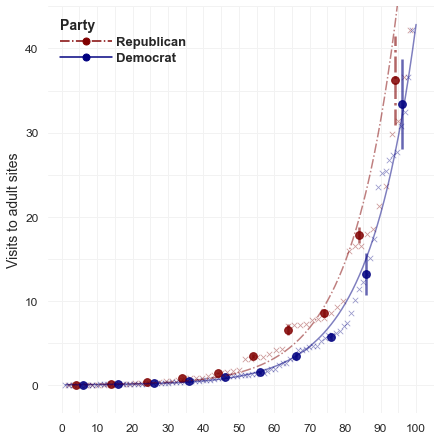

In [20]:
# (fold cell) Plot splits by party
scale = .7
fig, ax = plt.subplots(figsize=(9*scale, 9*scale))

# Scatterpoints for individuals
for party in ["R", "D"]:
    plt.scatter(
        data=df_visits.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_opts
    )

# Error bars
for party in ["R", "D"]:
    eb = plt.errorbar(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **errorbar_opts,
    )
    if party == "R":
        eb[-1][0].set_linestyle(errorlinestyle["R"])

# Scatter for the 2 parties x 10 deciles
for party in ["R", "D"]:
    plt.scatter(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_decile_opts
    )

# Connect deciles
running_var = "quantiles_adult_visits_prop"
for party in ["R", "D"]:
    y = df_visits.query(f"party=='{party}'")[outcome_var]
    x = df_visits.query(f"party=='{party}'")[running_var]
    x_fitted, y_fitted = fit_exp(x,y)
    plt.plot(x_fitted, y_fitted, color=palette[party], linestyle=errorlinestyle[party], **line_opts)

# Figure settings
ax.set_xticks(range(0,110,10))
ax.set_xlabel("")
ax.set_ylabel("Visits to adult sites", size=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylim(ax.get_ylim()[0], 45)
# Grids
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".95")
ax.yaxis.grid(True, which="both", color=".95")

# Custom Legend
rep_hand = mlines.Line2D([], [], 
                         color='maroon', marker='o', ls="-.",
                         markersize=7, label='Republican'
                        )
dem_hand = mlines.Line2D([], [], 
                         color='navy', marker='o', ls="-",
                         markersize=7, label='Democrat',
                        )
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand], 
    handlelength=4, 
    handletextpad=.3,
    labelspacing=.3,
#     size=20,
    title="Party", 
    frameon=False,
    prop={'weight':'bold', "size":13},
    title_fontproperties={'weight':'bold', 'size':14},
)
custom_legend._legend_box.align = "left"

sns.despine(left=True,bottom=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_proportion_adultsites_visits_by_party"))